In [7]:
import numpy as np
import sys as sys
import os as os
from geocluster import GeoCluster
from graph_library import generate_barbell_asy, assign_graph_metadata
import networkx as nx
import scipy as sc
import pylab as plt
import matplotlib.gridspec as gridspec
from matplotlib.animation import FFMpegWriter

#Generate graph 
graph,_ = generate_barbell_asy()
        
# initialise the code with parameters and graph 
graph.graph['name'] = 'barbell_asy'
pos = nx.spring_layout(graph, weight='weight')
graph = assign_graph_metadata(graph, pos=pos)

# initialise the code with parameters and graph
gc = GeoCluster(graph, T=np.logspace(-2., 3., 20), cutoff=1., use_spectral_gap = False)
                 
#Compute the OR curvatures are all the times
gc.compute_OR_curvatures()
gc.pos = [pos[i] for i in range(len(pos))]

#Save results for later analysis
gc.save_curvature()

  0%|          | 0/19 [00:00<?, ?it/s]


Graph: barbell_asy

Construct normalized Laplacian

Compute geodesic distance matrix

 Compute curvature at each markov time
compute mx
compute K


  5%|▌         | 1/19 [00:00<00:04,  4.09it/s]

save
compute mx
compute K


 11%|█         | 2/19 [00:00<00:04,  4.20it/s]

save
compute mx
compute K


 16%|█▌        | 3/19 [00:00<00:03,  4.14it/s]

save
compute mx
compute K


 21%|██        | 4/19 [00:00<00:03,  4.03it/s]

save
compute mx
compute K


 26%|██▋       | 5/19 [00:01<00:03,  3.97it/s]

save
compute mx
compute K


 32%|███▏      | 6/19 [00:01<00:03,  3.97it/s]

save
compute mx
compute K


 37%|███▋      | 7/19 [00:01<00:03,  3.95it/s]

save
compute mx
compute K


 42%|████▏     | 8/19 [00:02<00:02,  3.95it/s]

save
compute mx
compute K


 47%|████▋     | 9/19 [00:02<00:02,  3.94it/s]

save
compute mx
compute K


 53%|█████▎    | 10/19 [00:02<00:02,  3.95it/s]

save
compute mx
compute K


 58%|█████▊    | 11/19 [00:02<00:02,  3.95it/s]

save
compute mx
compute K


 63%|██████▎   | 12/19 [00:03<00:01,  4.00it/s]

save
compute mx
compute K


 68%|██████▊   | 13/19 [00:03<00:01,  4.03it/s]

save
compute mx
compute K


 74%|███████▎  | 14/19 [00:03<00:01,  4.03it/s]

save
compute mx
compute K


 79%|███████▉  | 15/19 [00:03<00:00,  4.11it/s]

save
compute mx
compute K


 84%|████████▍ | 16/19 [00:03<00:00,  4.18it/s]

save
compute mx
compute K


 89%|████████▉ | 17/19 [00:04<00:00,  3.71it/s]

save
compute mx
compute K


 95%|█████████▍| 18/19 [00:04<00:00,  3.08it/s]

save
compute mx
compute K


100%|██████████| 19/19 [00:05<00:00,  3.60it/s]

save


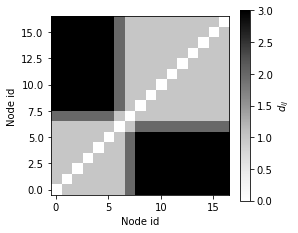

In [4]:
i = 6
j = 7

plt.figure(figsize=(4,3.5))
plt.imshow(gc.dist,aspect='auto', origin='auto',cmap='Greys')

ax1 = plt.gca()
#ax1.axvline(i, c='C0',lw=3,ls='--')
#ax1.axhline(i, c='C0',lw=3,ls='--')
#ax1.axvline(j, c='C1',lw=3,ls='--')
#ax1.axhline(j, c='C1',lw=3,ls='--')
ax1.set_xlabel('Node id')
ax1.set_ylabel('Node id')
plt.colorbar(label=r'$d_{ij}$')
plt.axis('square')

plt.savefig('distance.svg', bbox_inches='tight')

In [5]:
# compute all neighbourhood densities
def mx_comp(L, T, cutoff, i):
    N = np.shape(L)[0]

    def delta(i, n):
        p0 = np.zeros(n)
        p0[i] = 1.
        return p0

    mx_all, Nx_all = [], [] 
    mx_tmp = delta(i, N) #set initial condition
    T = [0,] + list(T) #add time 0
    
    for i in range(len((T))-1): 
        #compute exponential by increments (faster than from 0)
        mx_tmp = sc.sparse.linalg.expm_multiply(-(T[i+1]-T[i])*L, mx_tmp)

        Nx = np.argwhere(mx_tmp >= (1-cutoff)*np.max(mx_tmp))
        mx_all.append(sc.sparse.lil_matrix(mx_tmp[Nx]/np.sum(mx_tmp[Nx])))
        Nx_all.append(Nx)

    return mx_all, Nx_all


# compute curvature for an edge ij
def zeta_comp(mx_all, dist, it, e):
    import ot
    
    i, j = e[0], e[1]
    nt = len(mx_all[0][0])
    K = np.zeros(nt)

    Nx = np.array(mx_all[i][1][it]).flatten()
    Ny = np.array(mx_all[j][1][it]).flatten()
    mx = mx_all[i][0][it].toarray().flatten()
    my = mx_all[j][0][it].toarray().flatten()

    dNxNy = dist[Nx,:][:,Ny].copy(order='C')
    zeta = ot.emd(mx, my, dNxNy) 
            
    return zeta

# plot the curvature on the graph for a given time t
def plot_measure_graph(self, t, mx1, mx2, node_size = 100, edge_width = 1):

    edge_vmin = -np.max(abs(self.Kappa[:,t]))
    edge_vmax = np.max(abs(self.Kappa[:,t]))
              
    vmin = 0# -np.max(abs(mx))
    vmax = 1#np.max(abs(mx))
    mx1 /= np.max(mx1)
    mx2 /= np.max(mx2)

    node_size1, node_size2 = mx1*node_size, mx2*node_size 

    from matplotlib.markers import MarkerStyle
    ms1 = MarkerStyle('o', fillstyle = 'left')
    ms2 = MarkerStyle('o', fillstyle = 'right')
    node_color1 = 'C0'
    node_color2 = 'C1'

    nodes = nx.draw_networkx_nodes(self.G, pos = self.pos, node_size = node_size1, node_color = node_color1, 
                                   vmin = vmin, vmax = vmax,  cmap=plt.get_cmap('viridis'),node_shape=ms1,
                                  ax=gc.ax)
    edges = nx.draw_networkx_edges(self.G, pos = self.pos, width = edge_width, edge_color = '0.5', 
                                   edge_vmin = edge_vmin, edge_vmax = edge_vmax, edge_cmap=plt.get_cmap('coolwarm'),
                                  ax=gc.ax)

        #plt.colorbar(edges, label='Curvature')

    if self.node_labels:
        old_labels={}
        for i in self.G:
            old_labels[i] = str(i) + ' ' + self.G.node[i]['old_label']
        nx.draw_networkx_labels(self.G, pos = self.pos, labels = old_labels)
    nodes = nx.draw_networkx_nodes(self.G, pos = self.pos, node_size = node_size2, node_color = node_color2, vmin = vmin, vmax = vmax,  cmap=plt.get_cmap('viridis'),node_shape=ms2)

    limits = plt.axis('off') #turn axis off

def plot_transport_plan(zeta, mx1, mx2, ax1, ax2, ax3):       
   
    ax1.imshow((zeta.T),cmap='viridis',aspect='auto', origin='auto')
    #ax1.axvline(i, c='C0',ls='--')
    #ax1.axhline(i, c='C0',ls='--')
    #ax1.axvline(j, c='C1',ls='--')
    #ax1.axhline(j, c='C1',ls='--')
    ax1.set_xlabel('Node id')
    ax1.set_ylabel('Node id')
  
    ax2.bar(np.arange(len(mx1)), mx1,color='C0',log=False)
    ax2.set_xlim(-0.5,len(mx1)-0.5)
    #ax2.set_ylim(0.0,1)
    #ax2.axhline(0.1,ls='--',c='k',lw=0.8)
    ax2.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax2.set_ylabel('$p_x$')
    ax2.set_ylim([0,0.2])
    
    ax3.barh(np.arange(len(mx2)),mx2,color='C1',log=False)
    #ax3.axvline(0.1,ls='--',c='k',lw=0.8)
    ax3.set_ylim(-0.5,len(mx2)-0.5)
    #ax3.set_xlim(0.01,1)
    ax3.set_xlabel('$p_y$')
    ax3.set_xlim([0,0.2])

    ax3.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False)


    ax1.axvline(6.5,c='w',ls='--',lw=0.8)
    #ax1.axvline(9,c='w',ls='--',lw=0.8)
    ax1.axhline(6.5,c='w',ls='--',lw=0.8)
    #ax1.axhline(9,c='w',ls='--',lw=0.8)
    #ax2.axvline(6.5,c='k',ls='--',lw=0.8)
    #ax2.axvline(40,c='k',ls='--',lw=0.8)
    #ax3.axhline(6.5,c='k',ls='--',lw=0.8)
    #ax3.axhline(40,c='k',ls='--',lw=0.8)
    
    return ax1, ax2, ax3
    
%matplotlib notebook

<IPython.core.display.Javascript object>


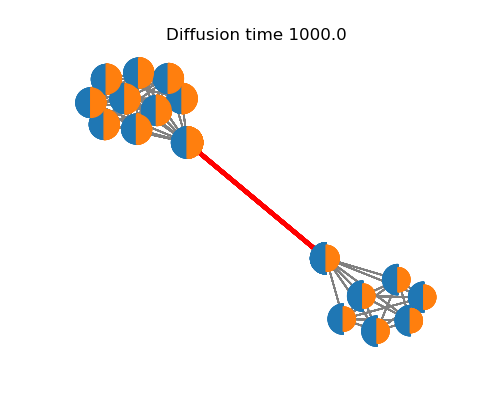

/home/gosztolai/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


In [6]:
i = 6
j = 7
mx_1, Nx_1 = mx_comp(gc.L,gc.T,gc.cutoff, i)
mx_2, Nx_2 = mx_comp(gc.L,gc.T,gc.cutoff, j)
    
fig = plt.figure(figsize=(5,4))
gc.ax = plt.subplot(111)

gc.node_labels = False

metadata = dict(title='Movie Test', artist='Matplotlib',comment='Movie support!')
writer = FFMpegWriter(fps=1, metadata=metadata)
with writer.saving(fig, "diffusion_between.mp4", 100):
    for t in range(len(gc.T)):       
        mx1, mx2 = mx_1[t].toarray().flatten(), mx_2[t].toarray().flatten()
        plot_measure_graph(gc, t, mx1, mx2,  node_size = 500, edge_width = 1)
        nx.draw_networkx_edges(gc.G, pos = gc.pos, edgelist=[(i,j),], edge_color='r',width = 3,ax=gc.ax)
        plt.title('Diffusion time ' + str(np.round(gc.T[t],2)))
        writer.grab_frame()


<IPython.core.display.Javascript object>


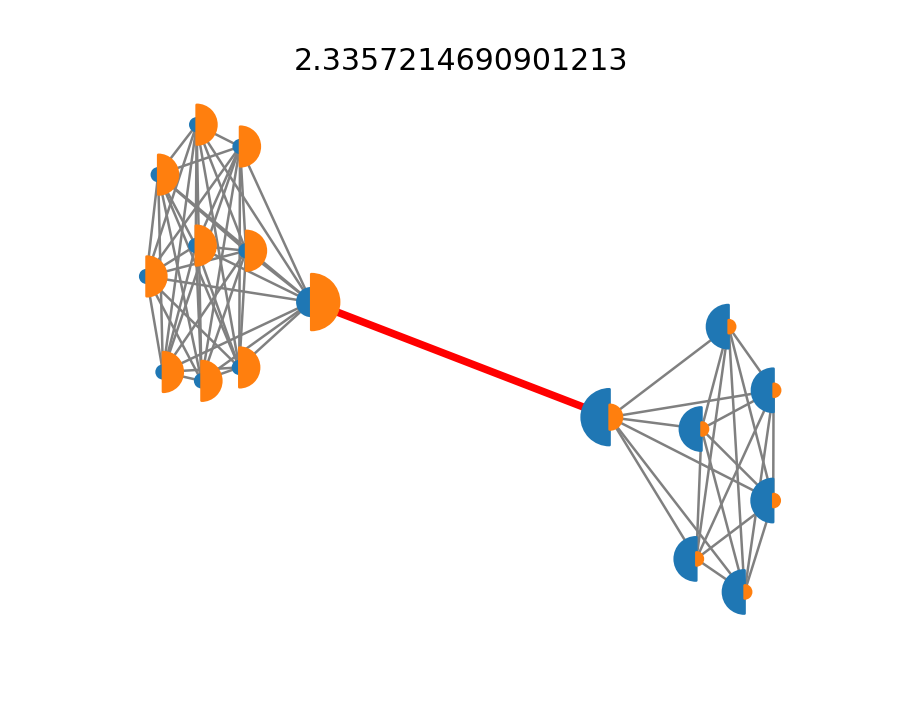

/home/gosztolai/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


In [8]:
t = 9

i = 6
j = 7

mx_1, Nx_1 = mx_comp(gc.L,gc.T,gc.cutoff, i)
mx_2, Nx_2 = mx_comp(gc.L,gc.T,gc.cutoff, j)
mx1, mx2 = mx_1[t].toarray().flatten(), mx_2[t].toarray().flatten()

fig = plt.figure(figsize=(5,4))
gc.ax = plt.subplot(111)

gc.node_labels = False
plot_measure_graph(gc, t, mx1, mx2,  node_size = 500, edge_width = 1)
nx.draw_networkx_edges(gc.G, pos = gc.pos, edgelist=[(i,j),], edge_color='r',width = 3,ax=gc.ax)
#, edge_color = '0.5', edge_vmin = edge_vmin, edge_vmax = edge_vmax, edge_cmap=plt.get_cmap('coolwarm'))

plt.title(gc.T[t])
plt.savefig('mxs.svg', bbox_inches='tight')

In [9]:
from multiprocessing import Pool
from tqdm import tqdm
from functools import partial

with Pool(processes = gc.workers) as p_mx:  #initialise the parallel computation
    mx_all = list(tqdm(p_mx.imap(partial(mx_comp, gc.L, gc.T, gc.cutoff), gc.G.nodes()), total = gc.n))

100%|██████████| 17/17 [00:00<00:00, 17.87it/s]


<IPython.core.display.Javascript object>


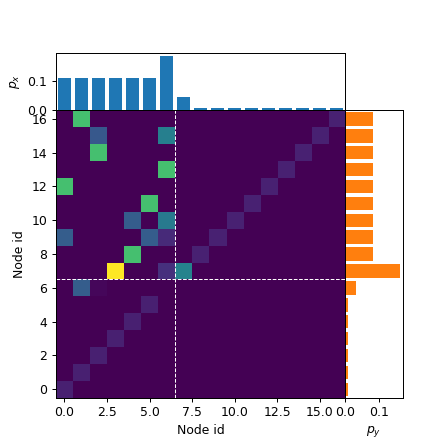

(<matplotlib.axes._subplots.AxesSubplot at 0x7f051474e4d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0514777250>)

In [46]:
t = 9
i = 6
j = 7

mx_1, Nx_1 = mx_comp(gc.L,gc.T,gc.cutoff, i)
mx_2, Nx_2 = mx_comp(gc.L,gc.T,gc.cutoff, j)
mx1, mx2 = mx_1[t].toarray().flatten(), mx_2[t].toarray().flatten()
zeta = zeta_comp(mx_all, gc.dist, t, (i,j))

fig= plt.figure(figsize=(5,5))
gs = gridspec.GridSpec(2, 2, height_ratios = [ 0.2, 1], width_ratios = [1,0.2] )
gs.update(wspace=0.00)
gs.update(hspace=0)
ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[0, 0])
ax3 = plt.subplot(gs[1, 1])
plot_transport_plan(zeta, mx1, mx2, ax1, ax2, ax3)

#plt.savefig('zeta.svg', bbox_inches='tight')

<IPython.core.display.Javascript object>


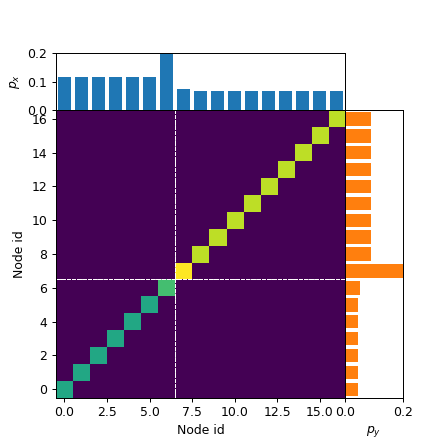

In [59]:
i = 6
j = 7

fig= plt.figure(figsize=(5,5))
gs = gridspec.GridSpec(2, 2, height_ratios = [ 0.2, 1], width_ratios = [1,0.2] )
gs.update(wspace=0.00)
gs.update(hspace=0)
ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[0, 0])
ax3 = plt.subplot(gs[1, 1])
mx_1, Nx_1 = mx_comp(gc.L,gc.T,gc.cutoff, i)
mx_2, Nx_2 = mx_comp(gc.L,gc.T,gc.cutoff, j)

metadata = dict(title='Movie Test', artist='Matplotlib',comment='Movie support!')
writer = FFMpegWriter(fps=1, metadata=metadata)
with writer.saving(fig, "OT_between.mp4", 100):
    for t in range(len(gc.T)):       
        zeta = zeta_comp(mx_all, gc.dist, t, (i,j))    
        mx1, mx2 = mx_1[t].toarray().flatten(), mx_2[t].toarray().flatten()
        ax1, ax2, ax3 = plot_transport_plan(zeta, mx1, mx2, ax1, ax2, ax3)
        writer.grab_frame()

<IPython.core.display.Javascript object>


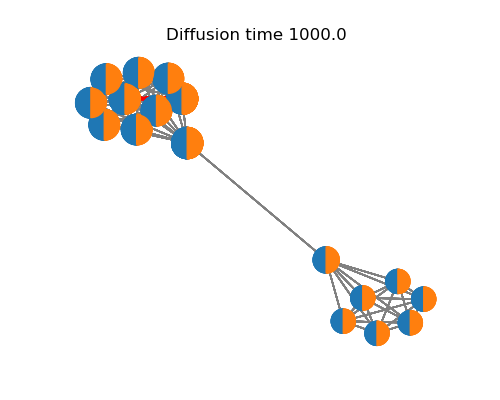

/home/gosztolai/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


In [14]:
i = 10
j = 12
mx_1, Nx_1 = mx_comp(gc.L,gc.T,gc.cutoff, i)
mx_2, Nx_2 = mx_comp(gc.L,gc.T,gc.cutoff, j)
    
fig = plt.figure(figsize=(5,4))
gc.ax = plt.subplot(111)

gc.node_labels = False

#, edge_color = '0.5', edge_vmin = edge_vmin, edge_vmax = edge_vmax, edge_cmap=plt.get_cmap('coolwarm'))

metadata = dict(title='Movie Test', artist='Matplotlib',comment='Movie support!')
writer = FFMpegWriter(fps=1, metadata=metadata)
with writer.saving(fig, "diffusion_within.mp4", 100):
    for t in range(len(gc.T)):       
        mx1, mx2 = mx_1[t].toarray().flatten(), mx_2[t].toarray().flatten()
        plot_measure_graph(gc, t, mx1, mx2,  node_size = 500, edge_width = 1)
        nx.draw_networkx_edges(gc.G, pos = gc.pos, edgelist=[(i,j),], edge_color='r',width = 3,ax=gc.ax)
        plt.title('Diffusion time ' + str(np.round(gc.T[t],2)))
        writer.grab_frame()

<IPython.core.display.Javascript object>


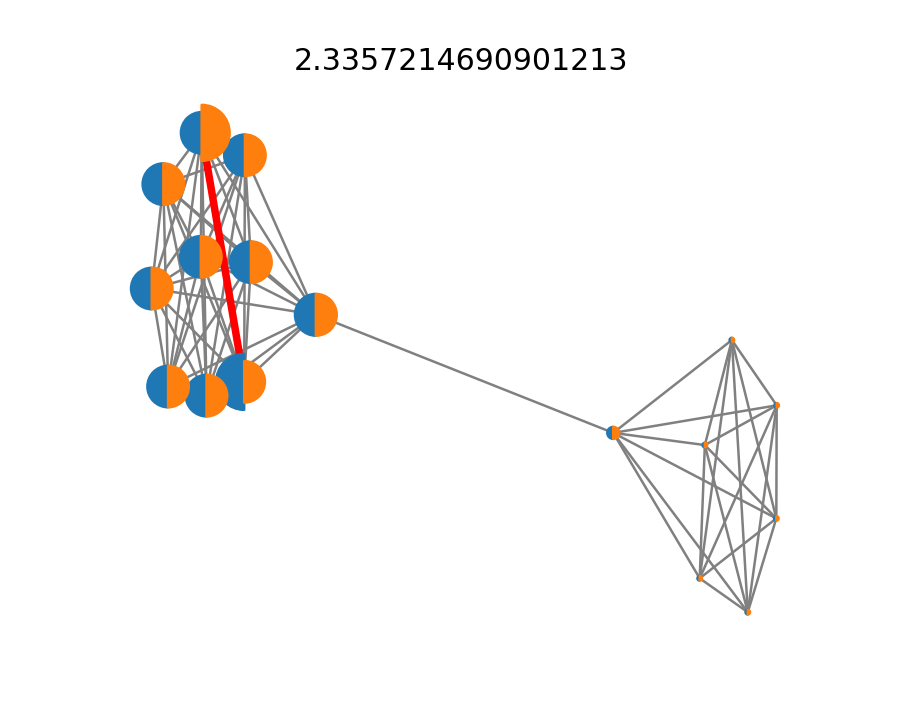

/home/gosztolai/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


In [21]:
t = 9

i = 10
j = 16

mx_1, Nx_1 = mx_comp(gc.L,gc.T,gc.cutoff, i)
mx_2, Nx_2 = mx_comp(gc.L,gc.T,gc.cutoff, j)
mx1, mx2 = mx_1[t].toarray().flatten(), mx_2[t].toarray().flatten()

fig = plt.figure(figsize=(5,4))
gc.ax = plt.subplot(111)

gc.node_labels = False
plot_measure_graph(gc, t, mx1, mx2,  node_size = 500, edge_width = 1)
nx.draw_networkx_edges(gc.G, pos = gc.pos, edgelist=[(i,j),], edge_color='r',width = 3,ax=gc.ax)
#, edge_color = '0.5', edge_vmin = edge_vmin, edge_vmax = edge_vmax, edge_cmap=plt.get_cmap('coolwarm'))

plt.title(gc.T[t])
plt.savefig('mxs_2.svg', bbox_inches='tight')

<IPython.core.display.Javascript object>


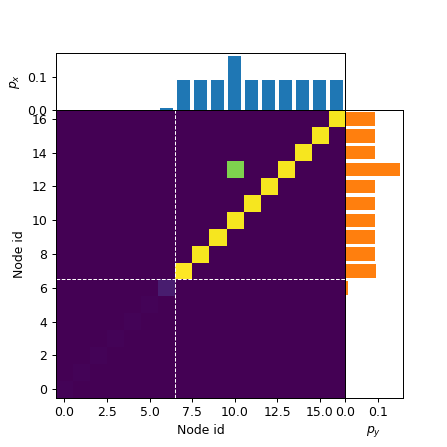

(<matplotlib.axes._subplots.AxesSubplot at 0x7f04f3624850>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f04f3a23e50>)

In [50]:
t = 9
i = 10
j = 13

mx_1, Nx_1 = mx_comp(gc.L,gc.T,gc.cutoff, i)
mx_2, Nx_2 = mx_comp(gc.L,gc.T,gc.cutoff, j)
mx1, mx2 = mx_1[t].toarray().flatten(), mx_2[t].toarray().flatten()
zeta = zeta_comp(mx_all, gc.dist, t, (i,j))

fig= plt.figure(figsize=(5,5))
gs = gridspec.GridSpec(2, 2, height_ratios = [ 0.2, 1], width_ratios = [1,0.2] )
gs.update(wspace=0.00)
gs.update(hspace=0)
ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[0, 0])
ax3 = plt.subplot(gs[1, 1])
plot_transport_plan(zeta, mx1, mx2, ax1, ax2, ax3)

#plt.savefig('zeta2.svg', bbox_inches='tight')

<IPython.core.display.Javascript object>


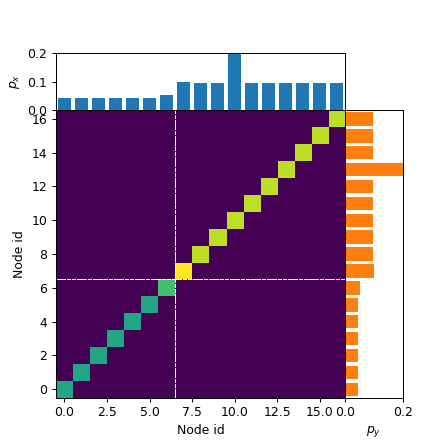

In [58]:
i = 10
j = 13

fig= plt.figure(figsize=(5,5))
gs = gridspec.GridSpec(2, 2, height_ratios = [ 0.2, 1], width_ratios = [1,0.2] )
gs.update(wspace=0.00)
gs.update(hspace=0)
ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[0, 0])
ax3 = plt.subplot(gs[1, 1])
mx_1, Nx_1 = mx_comp(gc.L,gc.T,gc.cutoff, i)
mx_2, Nx_2 = mx_comp(gc.L,gc.T,gc.cutoff, j)

metadata = dict(title='Movie Test', artist='Matplotlib',comment='Movie support!')
writer = FFMpegWriter(fps=1, metadata=metadata)
with writer.saving(fig, "OT_within.mp4", 100):
    for t in range(len(gc.T)):       
        zeta = zeta_comp(mx_all, gc.dist, t, (i,j))    
        mx1, mx2 = mx_1[t].toarray().flatten(), mx_2[t].toarray().flatten()
        ax1, ax2, ax3 = plot_transport_plan(zeta, mx1, mx2, ax1, ax2, ax3)
        writer.grab_frame()

<IPython.core.display.Javascript object>


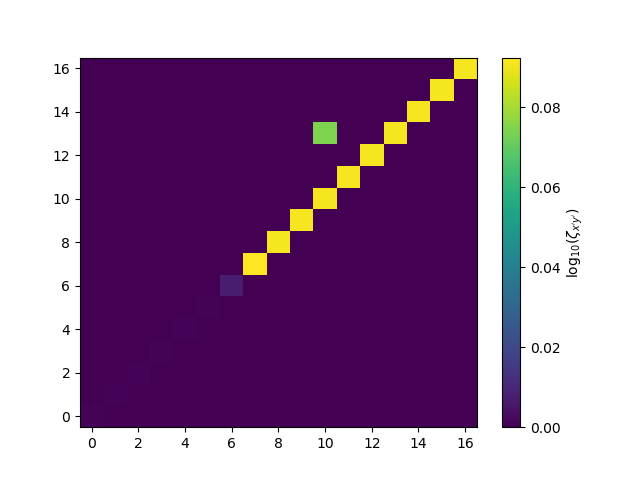

In [31]:
plt.figure()
plt.imshow((zeta.T),cmap='viridis',aspect='auto', origin='auto')
plt.colorbar(label=r'$\mathrm{log}_{10}(\zeta_{x^\prime y^\prime})$')
plt.savefig('colorbar_zeta.svg')

<IPython.core.display.Javascript object>


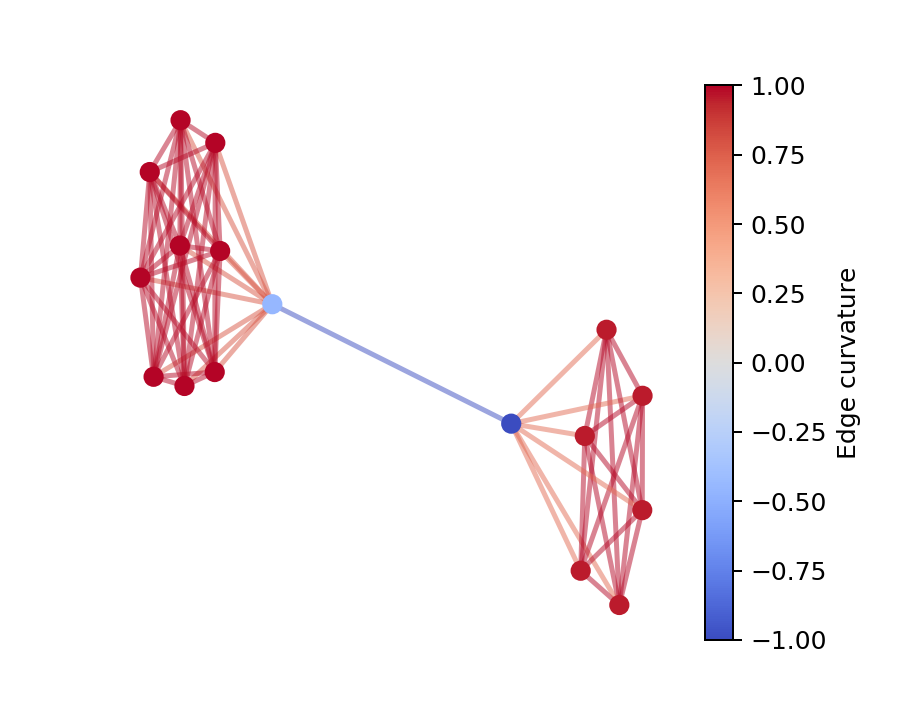

/home/gosztolai/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/home/gosztolai/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


In [22]:
t = 9

gc.figsize=(5,2)
gc.compute_node_curvature()

gc.plot_graph(10, node_size=50, edge_width=2, node_labels=False, node_colors=gc.Kappa_node.T[t], cluster=False)

plt.savefig('edge_curvature_graph.svg')